In [7]:
import shap
import pickle
import optuna

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna.distributions as D

from optuna.integration import OptunaSearchCV
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    f1_score,
    precision_recall_curve,
    roc_curve, 
    auc,
    make_scorer
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from catboost import (
    CatBoostClassifier,
    Pool, 
    cv, 
    EShapCalcType, 
    EFeaturesSelectionAlgorithm
)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

### Функции

In [8]:
# обучение базовой модели
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=None,
                 lr=None,
                 loss='MultiClass',
                 plot=False,
                 train_weight=None,
                 val_weight=None):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostClassifier(
        iterations = n_iter,
        learning_rate = lr,
        loss_function = loss,
        random_seed = 42,
        task_type='GPU'
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
#         early_stopping_rounds = 15,
        plot=plot
    )

    return model

# Чтение данных

In [ ]:
train_df = pd.read_parquet('/kaggle/input/full-dataset-alfa/train.parquet')
test_df = pd.read_parquet('/kaggle/input/full-dataset-alfa/test.parquet')

features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

# Обучение модели, кроссвалидация

In [7]:
train_df['target_bins'] = None
train_df.loc[train_df['target'] <= train_df['target'].quantile(0.333), 'target_bins'] = 'bin_0'
train_df.loc[
    (train_df['target'] > train_df['target'].quantile(0.333))
    & (train_df['target'] <= train_df['target'].quantile(0.666)), 
    'target_bins'
] = 'bin_1'
train_df.loc[train_df['target'] > train_df['target'].quantile(0.666), 'target_bins'] = 'bin_2'

le = LabelEncoder()
train_df['target_bins'] = le.fit_transform(train_df['target_bins'])

0:	learn: 1.0883424	test: 1.0885087	best: 1.0885087 (0)	total: 30.8ms	remaining: 1m 32s
100:	learn: 0.7880254	test: 0.7928453	best: 0.7928453 (100)	total: 2.14s	remaining: 1m 1s
200:	learn: 0.7306376	test: 0.7371023	best: 0.7371023 (200)	total: 3.66s	remaining: 51s
300:	learn: 0.7061308	test: 0.7136699	best: 0.7136699 (300)	total: 5.12s	remaining: 45.9s
400:	learn: 0.6922990	test: 0.7005084	best: 0.7005084 (400)	total: 6.64s	remaining: 43.1s
500:	learn: 0.6828486	test: 0.6920247	best: 0.6920247 (500)	total: 8.09s	remaining: 40.3s
600:	learn: 0.6756481	test: 0.6857584	best: 0.6857584 (600)	total: 9.53s	remaining: 38s
700:	learn: 0.6700746	test: 0.6812575	best: 0.6812575 (700)	total: 11s	remaining: 36.1s
800:	learn: 0.6655712	test: 0.6776977	best: 0.6776977 (800)	total: 12.5s	remaining: 34.2s
900:	learn: 0.6618497	test: 0.6749948	best: 0.6749948 (900)	total: 14s	remaining: 32.6s
1000:	learn: 0.6584278	test: 0.6725319	best: 0.6725319 (1000)	total: 15.4s	remaining: 30.8s
1100:	learn: 0.655

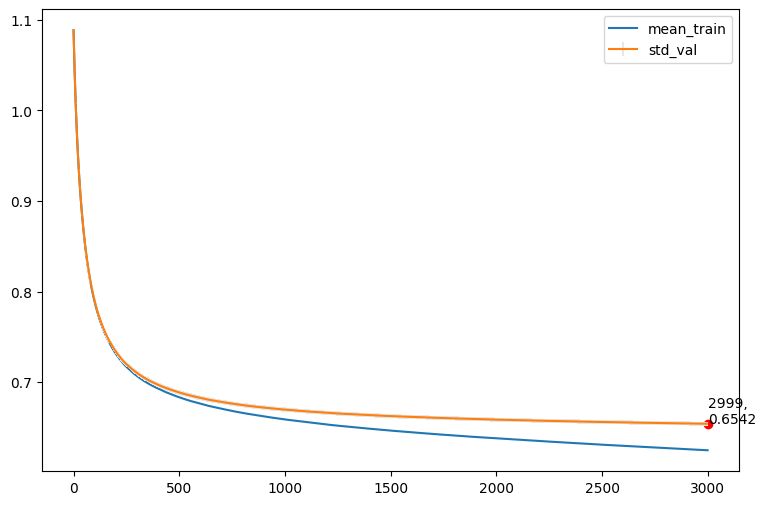

In [11]:
train_scores = []
val_scores = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in cv.split(train_df[features], train_df['target_bins']):
    x_train, y_train = train_df.loc[train_index, features], train_df.loc[train_index, 'target_bins']
    x_val, y_val = train_df.loc[val_index, features], train_df.loc[val_index, 'target_bins']

    model = fit_catboost(x_train, x_val, y_train, y_val, cat_features, 3000, 0.02)
    
    train_scores.append(
        np.array(model.evals_result_['learn']['MultiClass'])
    )
    val_scores.append(
        np.array(model.evals_result_['validation']['MultiClass'])
    )

mean_train_score = np.mean(np.array(train_scores),axis=0)
mean_val_score = np.mean(np.array(val_scores),axis=0)
std_val_score = np.std(np.array(val_scores),axis=0)

plt.figure(figsize=(9, 6))
plt.plot(range(0,len(mean_train_score)),mean_train_score, label = 'mean_train')
plt.errorbar(
    range(0,len(mean_val_score),5),
    mean_val_score[::5],
    yerr=std_val_score[::5],
    ecolor='0.9',
    label='std_val',
    barsabove=False
)
plt.legend()
plt.scatter(np.argmin(mean_val_score),np.min(mean_val_score),c='red')
plt.annotate(
    f'{np.argmin(mean_val_score)},\n{round(np.min(mean_val_score), 4)}', 
    (np.argmin(mean_val_score),np.min(mean_val_score))
)
plt.show()

In [16]:
features_train, features_val, target_train, target_val = train_test_split(
    train_df[features],
    train_df['target_bins'], 
    test_size=0.3,
    random_state=42
)

model = fit_catboost(features_train, features_val, target_train, target_val, cat_features, 3000, 0.02)

print(
    classification_report(
        target_val, 
        model.predict(features_val),
        target_names = unique_labels(le.inverse_transform(target_val))
    ) 
)

0:	learn: 1.0883405	test: 1.0883464	best: 1.0883464 (0)	total: 28.2ms	remaining: 1m 24s
100:	learn: 0.7882184	test: 0.7900561	best: 0.7900561 (100)	total: 2.06s	remaining: 59.3s
200:	learn: 0.7313440	test: 0.7346893	best: 0.7346893 (200)	total: 3.92s	remaining: 54.6s
300:	learn: 0.7063973	test: 0.7110737	best: 0.7110737 (300)	total: 5.68s	remaining: 51s
400:	learn: 0.6923920	test: 0.6983214	best: 0.6983214 (400)	total: 7.17s	remaining: 46.5s
500:	learn: 0.6826907	test: 0.6898524	best: 0.6898524 (500)	total: 8.59s	remaining: 42.8s
600:	learn: 0.6757887	test: 0.6842308	best: 0.6842308 (600)	total: 10.5s	remaining: 41.9s
700:	learn: 0.6702392	test: 0.6798528	best: 0.6798528 (700)	total: 12.3s	remaining: 40.4s
800:	learn: 0.6654716	test: 0.6763791	best: 0.6763791 (800)	total: 14.1s	remaining: 38.7s
900:	learn: 0.6616248	test: 0.6738419	best: 0.6738419 (900)	total: 15.6s	remaining: 36.3s
1000:	learn: 0.6582572	test: 0.6716442	best: 0.6716442 (1000)	total: 17s	remaining: 33.9s
1100:	learn: 0

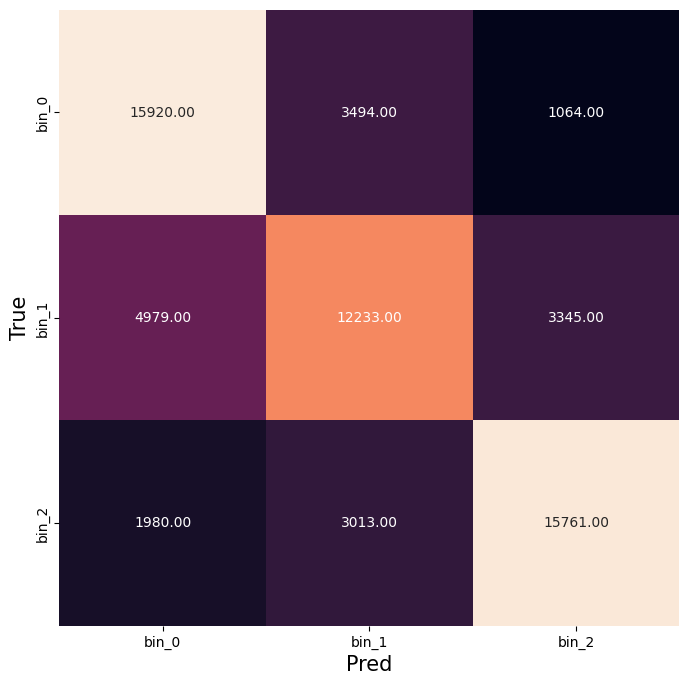

In [19]:
cm = confusion_matrix(target_val, model.predict(features_val))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='.2f', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

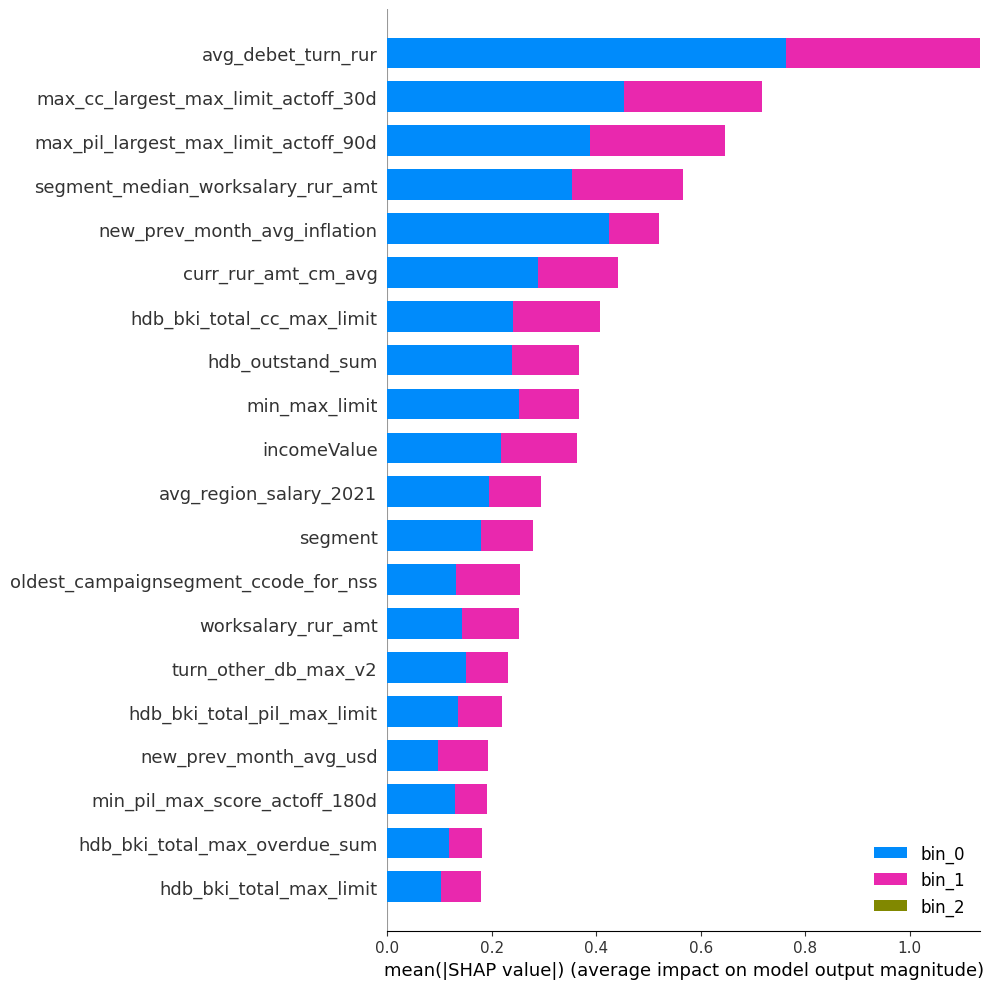

,feature,importance
0,avg_debet_turn_rur,1.134211
1,max_cc_largest_max_limit_actoff_30d,0.716608
2,max_pil_largest_max_limit_actoff_90d,0.646130
3,segment_median_worksalary_rur_amt,0.565539
4,new_prev_month_avg_inflation,0.520152


In [18]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)

shap.summary_plot(
    shap_values, 
    features_val, 
    class_names = unique_labels(le.inverse_transform(target_val)),
    plot_size = (10,  10)
)

shap_importance = (
    pd.DataFrame(
        {
            "feature":  features_train.columns, 
            "importance": sum([np.mean(np.abs(shap_class), axis=0) for shap_class in shap_values])
        }
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

# Отбор признаков

### Факторный анализ

In [20]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
42,first_salary_income,0.057865
83,brand,0.015298
84,hdb_bki_other_active_auto_month_payments_sum,0.015125
87,product_depozity_voc_features_full_voc_without...,0.014464
116,part_last_position_ccode,0.005963
127,channel_pretenzii_voc_features_full_avg_mark,0.003901
128,part_pre_last_position_ccode,0.003611
146,car_country,0.001900
148,min_cc_max_ul_actoff_180_30_inc,0.001781
155,min_cc_max_pilot_score_actoff_180d,0.001331


179

In [21]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:8]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

187

In [22]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
42,first_salary_income,0.057865
83,brand,0.015298
84,hdb_bki_other_active_auto_month_payments_sum,0.015125
87,product_depozity_voc_features_full_voc_without...,0.014464
102,position_median_worksalary_rur_amt,0.007979
104,channel_bankomaty_voc_features_full_voc_not_nu...,0.007717
116,part_last_position_ccode,0.005963
127,channel_pretenzii_voc_features_full_avg_mark,0.003901
128,part_pre_last_position_ccode,0.003611
137,position_min_worksalary_rur_amt,0.002451


172

In [23]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:10]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

182

In [24]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """
    df_copy = df.copy()
    df_copy['random'] = np.random.uniform(0, 1, df_copy.shape[0])

    pool_train = Pool(
        df_copy[features + ['random']],
        df_copy['target_bins'],
        cat_features = cat_features
    )

    simple_model = CatBoostClassifier(
        iterations=3000,
        learning_rate=0.02,
        loss_function='MultiClass',
        random_seed=42,
        task_type='GPU'
    )

    simple_model.fit(
        pool_train,
        verbose=100,
        early_stopping_rounds = 15,
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df_copy[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {
                "feature":  features + ['random'], 
                "importance": sum([np.mean(np.abs(shap_class), axis=0) for shap_class in shap_values])
            }
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 1.0883468	total: 31.8ms	remaining: 1m 35s
100:	learn: 0.7889655	total: 1.94s	remaining: 55.8s
200:	learn: 0.7321648	total: 3.64s	remaining: 50.8s
300:	learn: 0.7074457	total: 5.44s	remaining: 48.7s
400:	learn: 0.6937194	total: 7.06s	remaining: 45.8s
500:	learn: 0.6840349	total: 8.49s	remaining: 42.4s
600:	learn: 0.6770649	total: 9.9s	remaining: 39.5s
700:	learn: 0.6715033	total: 11.4s	remaining: 37.4s
800:	learn: 0.6671482	total: 13s	remaining: 35.6s
900:	learn: 0.6633172	total: 14.7s	remaining: 34.3s
1000:	learn: 0.6599618	total: 16.5s	remaining: 32.9s
1100:	learn: 0.6570290	total: 18.1s	remaining: 31.1s
1200:	learn: 0.6543508	total: 19.7s	remaining: 29.6s
1300:	learn: 0.6519943	total: 21.2s	remaining: 27.7s
1400:	learn: 0.6497532	total: 22.7s	remaining: 25.9s
1500:	learn: 0.6479058	total: 24.4s	remaining: 24.3s
1600:	learn: 0.6460500	total: 26s	remaining: 22.7s
1700:	learn: 0.6441650	total: 27.8s	remaining: 21.2s
1800:	learn: 0.6425667	total: 29.5s	remaining: 19.6s
1900:	le

,feature,importance
74,new_this_month_avg_broad_money_sa,0.020188
97,product_other_depos_ratio_hy,0.009836
101,channel_chatbot_voc_features_full_voc_without_...,0.008278
104,channel_bankomaty_voc_features_full_voc_not_nu...,0.007717
105,channel_ivr_voc_features_36m_voc_not_null_flag,0.007470
108,channel_bankomaty_voc_features_3m_mark_eq_5_flag,0.007243
109,transaction_category_hotels_sum_amt_m2,0.007097
110,channel_mobilnoe_prilozhenie_am_voc_features_1...,0.007056
111,turn_cc_db_sum_v2,0.007008
112,transaction_category_money_send_sum_cnt_m2,0.006457


107

In [25]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:5]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

112

### RecursiveByShapValues

In [32]:
deleted_features = []

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_df):
    print(f'Начало фолда\n')

    cross_f_train, cross_f_val = train_df[features].loc[train_index], train_df[features].loc[val_index]
    cross_t_train, cross_t_val = train_df['target_bins'].loc[train_index], train_df['target_bins'].loc[val_index]

    pool_train = Pool(
        cross_f_train[selected_features],
        cross_t_train,
        cat_features = selected_features_cat
    )

    pool_val = Pool(
        cross_f_val[selected_features],
        cross_t_val,
        cat_features = selected_features_cat
    )

    model = CatBoostClassifier(
        iterations = 3000,
        learning_rate = 0.02,
        loss_function = 'MultiClass',
        random_seed = 42,
        task_type='GPU'
    )

    feature_selection = model.select_features(
        pool_train,
        eval_set=pool_val,
        features_for_select=list(range(pool_train.num_col())),
        num_features_to_select=40,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        plot=True,
        verbose=False
    )
    
    fold_bad_features = (
        feature_selection['eliminated_features_names']
        [
            :feature_selection['loss_graph']['loss_values']
            .index(min(feature_selection['loss_graph']['loss_values']))
        ]
    )
    deleted_features.append(fold_bad_features)

deleted_features = list(set(deleted_features[0]) & set(deleted_features[1]) & set(deleted_features[2]))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

Начало фолда



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
bestTest = 0.6538426612
bestIteration = 2999
Feature #105 eliminated
Feature #94 eliminated
Feature #90 eliminated
Feature #106 eliminated
Feature #107 eliminated
Feature #100 eliminated
Feature #111 eliminated
Feature #96 eliminated
Feature #109 eliminated
Feature #87 eliminated
Feature #76 eliminated
Feature #91 eliminated
Feature #108 eliminated
Feature #86 eliminated
Feature #102 eliminated
Feature #77 eliminated
Feature #93 eliminated
Feature #88 eliminated
Feature #99 eliminated
Feature #79 eliminated
Feature #82 eliminated
Feature #98 eliminated
Feature #62 eliminated
Feature #72 eliminated
Feature #85 eliminated
Feature #84 eliminated
Feature #103 eliminated
Feature #80 eliminated
Feature #104 eliminated
Feature #110 eliminated
Feature #66 eliminated
Feature #73 eliminated
Feature #38 eliminated
Step #2 out of 3
bestTest = 0.652479394
bestIteration = 2999
Feature #25 eliminated
Feature #65 eliminated
Feature #89 eliminated
Feature #71 eliminated
Feature #95 eli

Начало фолда



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
bestTest = 0.6576293124
bestIteration = 2999
Feature #57 eliminated
Feature #109 eliminated
Feature #106 eliminated
Feature #93 eliminated
Feature #85 eliminated
Feature #111 eliminated
Feature #107 eliminated
Feature #108 eliminated
Feature #76 eliminated
Feature #105 eliminated
Feature #88 eliminated
Feature #102 eliminated
Feature #77 eliminated
Feature #100 eliminated
Feature #87 eliminated
Feature #80 eliminated
Feature #95 eliminated
Feature #103 eliminated
Feature #84 eliminated
Feature #110 eliminated
Feature #72 eliminated
Feature #86 eliminated
Feature #82 eliminated
Feature #92 eliminated
Feature #104 eliminated
Feature #94 eliminated
Feature #63 eliminated
Feature #90 eliminated
Feature #91 eliminated
Feature #96 eliminated
Feature #38 eliminated
Feature #89 eliminated
Feature #50 eliminated
Step #2 out of 3
bestTest = 0.6570580033
bestIteration = 2999
Feature #79 eliminated
Feature #25 eliminated
Feature #101 eliminated
Feature #81 eliminated
Feature #99 e

Начало фолда



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
bestTest = 0.6520055505
bestIteration = 2999
Feature #86 eliminated
Feature #87 eliminated
Feature #106 eliminated
Feature #88 eliminated
Feature #77 eliminated
Feature #76 eliminated
Feature #111 eliminated
Feature #108 eliminated
Feature #105 eliminated
Feature #109 eliminated
Feature #102 eliminated
Feature #93 eliminated
Feature #91 eliminated
Feature #94 eliminated
Feature #85 eliminated
Feature #100 eliminated
Feature #89 eliminated
Feature #82 eliminated
Feature #84 eliminated
Feature #70 eliminated
Feature #95 eliminated
Feature #103 eliminated
Feature #110 eliminated
Feature #104 eliminated
Feature #78 eliminated
Feature #101 eliminated
Feature #63 eliminated
Feature #57 eliminated
Feature #92 eliminated
Feature #96 eliminated
Feature #38 eliminated
Feature #90 eliminated
Feature #107 eliminated
Step #2 out of 3
bestTest = 0.6512906886
bestIteration = 2999
Feature #25 eliminated
Feature #71 eliminated
Feature #65 eliminated
Feature #64 eliminated
Feature #50 e

,feature,importance
3,segment_median_worksalary_rur_amt,0.565539
10,avg_region_salary_2021,0.294542
21,new_this_month_avg_usd,0.154057
26,mob_cover_days,0.128595
46,avg_6m_personal_services,0.052390
51,transaction_category_general_store_inc_cnt_2m,0.046469
60,product_zarplatnaja_karta_voc_features_3m_voc_...,0.033759
64,avg_6m_building_services,0.025024
65,profit_income_out_rur_amt_9m,0.023693
66,cntOnnRinCallAvg6m,0.021866


In [37]:
# deleted_features = (
#     shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[5:]
# )
selected_features = [f for f in selected_features if f not in deleted_features]
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

65

0:	learn: 1.0883423	test: 1.0885088	best: 1.0885088 (0)	total: 23.5ms	remaining: 1m 10s
100:	learn: 0.7879952	test: 0.7928300	best: 0.7928300 (100)	total: 1.62s	remaining: 46.5s
200:	learn: 0.7306497	test: 0.7370983	best: 0.7370983 (200)	total: 3.18s	remaining: 44.3s
300:	learn: 0.7061674	test: 0.7135285	best: 0.7135285 (300)	total: 4.74s	remaining: 42.5s
400:	learn: 0.6924733	test: 0.7006055	best: 0.7006055 (400)	total: 6.25s	remaining: 40.5s
500:	learn: 0.6829582	test: 0.6921371	best: 0.6921371 (500)	total: 7.51s	remaining: 37.4s
600:	learn: 0.6759242	test: 0.6859307	best: 0.6859307 (600)	total: 8.94s	remaining: 35.7s
700:	learn: 0.6702990	test: 0.6812392	best: 0.6812392 (700)	total: 10.4s	remaining: 34.1s
800:	learn: 0.6655033	test: 0.6773394	best: 0.6773394 (800)	total: 11.9s	remaining: 32.8s
900:	learn: 0.6613685	test: 0.6742006	best: 0.6742006 (900)	total: 13.4s	remaining: 31.3s
1000:	learn: 0.6579177	test: 0.6717457	best: 0.6717457 (1000)	total: 15s	remaining: 29.9s
1100:	learn:

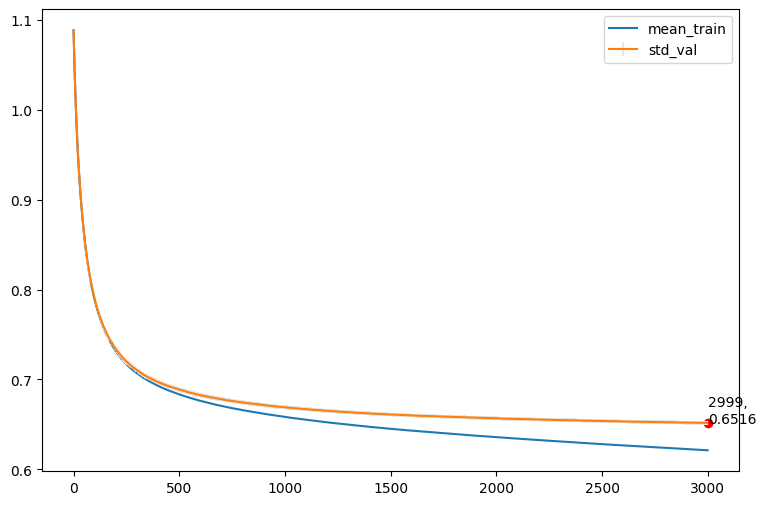

In [45]:
train_scores = []
val_scores = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in cv.split(train_df[selected_features], train_df['target_bins']):
    x_train, y_train = train_df.loc[train_index, selected_features], train_df.loc[train_index, 'target_bins']
    x_val, y_val = train_df.loc[val_index, selected_features], train_df.loc[val_index, 'target_bins']

    model = fit_catboost(x_train, x_val, y_train, y_val, selected_features_cat, 3000, 0.02)
    
    train_scores.append(
        np.array(model.evals_result_['learn']['MultiClass'])
    )
    val_scores.append(
        np.array(model.evals_result_['validation']['MultiClass'])
    )

mean_train_score = np.mean(np.array(train_scores),axis=0)
mean_val_score = np.mean(np.array(val_scores),axis=0)
std_val_score = np.std(np.array(val_scores),axis=0)

plt.figure(figsize=(9, 6))
plt.plot(range(0,len(mean_train_score)),mean_train_score, label = 'mean_train')
plt.errorbar(
    range(0,len(mean_val_score),5),
    mean_val_score[::5],
    yerr=std_val_score[::5],
    ecolor='0.9',
    label='std_val',
    barsabove=False
)
plt.legend()
plt.scatter(np.argmin(mean_val_score),np.min(mean_val_score),c='red')
plt.annotate(
    f'{np.argmin(mean_val_score)},\n{round(np.min(mean_val_score), 4)}', 
    (np.argmin(mean_val_score),np.min(mean_val_score))
)
plt.show()

# Подбор гиперпараметров

### Подбираем lr

In [33]:
f1_scorer = make_scorer(
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
)

params = {
    'iterations': D.IntDistribution(4000, 4000),
    'learning_rate': D.FloatDistribution(0.01, 0.03)
}

model = CatBoostClassifier(
    loss_function = 'MultiClass',
    random_seed = 42,
    cat_features = selected_features_cat,
    early_stopping_rounds=50,
    task_type='GPU',
    silent=True
)

study = optuna.create_study(direction='maximize')

optuna_search = OptunaSearchCV(
    model,
    params,
    cv=3,
    n_trials=10,
    study=study,
    scoring='accuracy'
)

optuna_search.fit(train_df[selected_features], train_df['target_bins'])

print('Best hyperparameters:', optuna_search.best_params_)
print('Best score:', optuna_search.best_score_)

### Подбираем остальные гиперпараметры

In [46]:
f1_scorer = make_scorer(
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
)

params = {
    'iterations': D.IntDistribution(3000, 3000),
    'learning_rate': D.FloatDistribution(0.01, 0.02),
    'depth': D.IntDistribution(4, 10),
    'l2_leaf_reg': D.FloatDistribution(0.01, 10.0),
    'random_strength': D.FloatDistribution(0.1, 6.0),
}

model = CatBoostClassifier(
    loss_function='MultiClass',
    random_seed=42,
    cat_features=selected_features_cat,
    early_stopping_rounds=50,
    task_type='GPU',
    silent=True
)

study = optuna.create_study(direction='maximize')

optuna_search = OptunaSearchCV(
    model,
    params,
    cv=3,
    n_trials=30,
    study=study,
    scoring=f1_scorer
)

optuna_search.fit(train_df[selected_features], train_df['target_bins'])

print('Best hyperparameters:', optuna_search.best_params_)
print('Best score:', optuna_search.best_score_)

[I 2024-02-24 16:50:24,413] A new study created in memory with name: no-name-6b053def-8e7e-411f-ae9b-5ea869e4a50b
/tmp/ipykernel_34/2626351919.py:24: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2024-02-24 16:52:54,411] Trial 0 finished with value: 0.7117947715936283 and parameters: {'iterations': 3000, 'learning_rate': 0.01832560273031289, 'depth': 7, 'l2_leaf_reg': 4.025784169858308, 'random_strength': 5.7328480979977146}. Best is trial 0 with value: 0.7117947715936283.
[I 2024-02-24 16:59:55,054] Trial 1 finished with value: 0.7126397746879979 and parameters: {'iterations': 3000, 'learning_rate': 0.018247573731394295, 'depth': 10, 'l2_leaf_reg': 8.154290321101977, 'random_strength': 1.9008274720403495}. Best is trial 1 with value: 0.7126397746879979.
[I 2024-02-24 17:06:59,563] Trial 2 finished with value: 0.711801658043831 and parameters: {'iterations': 3000, 'learning_rate': 0.012375788588601147, 'depth'

Best hyperparameters: {'iterations': 3000, 'learning_rate': 0.019366037408150093, 'depth': 9, 'l2_leaf_reg': 1.5674812461155159, 'random_strength': 4.129731117024168}
Best score: 0.7133753321143801


# Обучение и сохранение

### Модель, обученная только на трейне

In [47]:
features_train, features_val, target_train, target_val = train_test_split(
    train_df[features],
    train_df['target_bins'], 
    test_size=0.3,
    random_state=42
)

In [58]:
param1 = {'iterations': 3000, 'learning_rate': 0.019366037408150093, 'depth': 9, 'l2_leaf_reg': 1.5674812461155159, 'random_strength': 4.129731117024168}
param2 = {'iterations': 3000, 'learning_rate': 0.019170935682612845, 'depth': 9, 'l2_leaf_reg': 1.4765324586451405, 'random_strength': 3.8500148416697435}
param3 = {'iterations': 3000, 'learning_rate': 0.01852928871902487, 'depth': 8, 'l2_leaf_reg': 4.459438165011174, 'random_strength': 4.428266790823374}


pool_train = Pool(
    features_train[selected_features],
    target_train,
    cat_features = selected_features_cat
)

pool_val = Pool(
    features_val[selected_features],
    target_val,
    cat_features = selected_features_cat
)

model = CatBoostClassifier(
    **param3,
    loss_function='MultiClass',
    
    random_seed=42,
    task_type='GPU'
)

model.fit(
    pool_train,
    verbose=100,
    eval_set=pool_val
)

print(
    classification_report(
        target_val, 
        model.predict(features_val[selected_features]),
        target_names = unique_labels(le.inverse_transform(target_val))
    ) 
)

0:	learn: 1.0882473	test: 1.0882843	best: 1.0882843 (0)	total: 38.7ms	remaining: 1m 56s
100:	learn: 0.7738249	test: 0.7773922	best: 0.7773922 (100)	total: 2.47s	remaining: 1m 10s
200:	learn: 0.7159163	test: 0.7222803	best: 0.7222803 (199)	total: 4.72s	remaining: 1m 5s
300:	learn: 0.6919494	test: 0.7007810	best: 0.7007810 (300)	total: 6.86s	remaining: 1m 1s
400:	learn: 0.6786071	test: 0.6897601	best: 0.6897601 (400)	total: 8.97s	remaining: 58.1s
500:	learn: 0.6688533	test: 0.6824267	best: 0.6824267 (500)	total: 11.4s	remaining: 56.7s
600:	learn: 0.6609633	test: 0.6769648	best: 0.6769648 (600)	total: 13.4s	remaining: 53.6s
700:	learn: 0.6537066	test: 0.6724775	best: 0.6724775 (700)	total: 15.4s	remaining: 50.6s
800:	learn: 0.6477761	test: 0.6691039	best: 0.6691039 (800)	total: 17.4s	remaining: 47.7s
900:	learn: 0.6425304	test: 0.6666000	best: 0.6666000 (900)	total: 19.6s	remaining: 45.6s
1000:	learn: 0.6376911	test: 0.6644020	best: 0.6644020 (1000)	total: 21.7s	remaining: 43.4s
1100:	lea

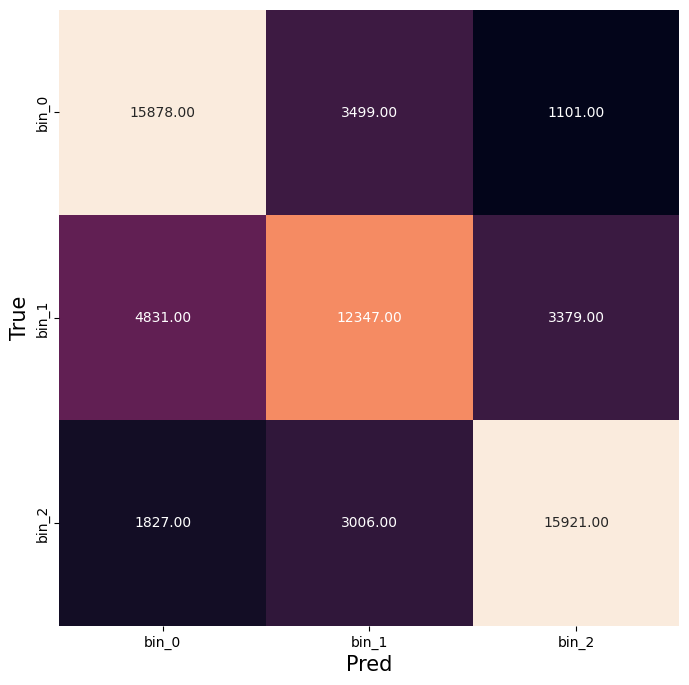

In [59]:
cm = confusion_matrix(target_val, model.predict(features_val[selected_features]))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='.2f', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

In [42]:
with open('/kaggle/working/3cl_33_67_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [60]:
model.save_model('/kaggle/working/train_3cl_333_666_model_clf_3')

### Модель, обученная на всех данных

In [61]:
pool_train = Pool(
    train_df[selected_features],
    train_df['target_bins'],
    cat_features = selected_features_cat
)

model = CatBoostClassifier(
    **param3,
    loss_function='MultiClass',
    random_seed=42,
    task_type='GPU'
)

model.fit(
    pool_train,
    verbose=100,
)

0:	learn: 1.0882159	total: 40.9ms	remaining: 2m 2s
100:	learn: 0.7739513	total: 2.53s	remaining: 1m 12s
200:	learn: 0.7164969	total: 4.72s	remaining: 1m 5s
300:	learn: 0.6925930	total: 7.07s	remaining: 1m 3s
400:	learn: 0.6793838	total: 9.17s	remaining: 59.4s
500:	learn: 0.6701629	total: 11.4s	remaining: 56.8s
600:	learn: 0.6629814	total: 13.6s	remaining: 54.1s
700:	learn: 0.6566530	total: 15.7s	remaining: 51.6s
800:	learn: 0.6514106	total: 18s	remaining: 49.4s
900:	learn: 0.6465322	total: 20.3s	remaining: 47.3s
1000:	learn: 0.6425373	total: 22.7s	remaining: 45.3s
1100:	learn: 0.6387929	total: 24.8s	remaining: 42.9s
1200:	learn: 0.6351948	total: 27.2s	remaining: 40.8s
1300:	learn: 0.6319271	total: 29.6s	remaining: 38.7s
1400:	learn: 0.6288099	total: 31.9s	remaining: 36.4s
1500:	learn: 0.6259173	total: 34.2s	remaining: 34.2s
1600:	learn: 0.6231112	total: 36.6s	remaining: 32s
1700:	learn: 0.6204929	total: 39.1s	remaining: 29.8s
1800:	learn: 0.6179197	total: 41.3s	remaining: 27.5s
1900:	l

In [62]:
model.save_model('/kaggle/working/full_3cl_333_666_model_clf_3')